In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils import spectral_norm
import random

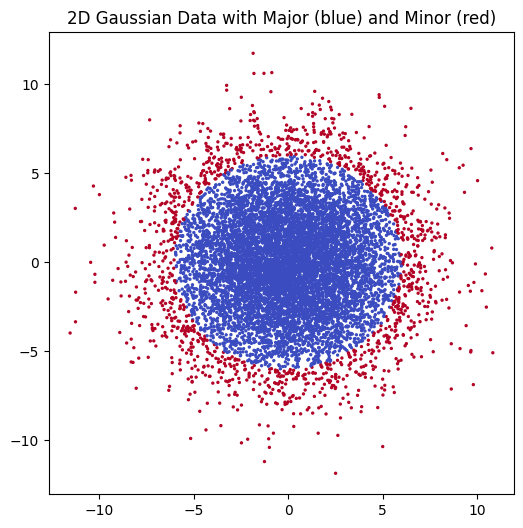

In [21]:
def generate_gaussian_dataset(n_samples=10000, threshold=6, sigma=3.0):
    X = np.random.randn(n_samples, 2) * sigma
    distances = np.linalg.norm(X, axis=1)
    labels = (distances > threshold).astype(int)  # 0 = major, 1 = minor
    return X.astype(np.float32), labels

X, labels = generate_gaussian_dataset()
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='coolwarm', s=2)
plt.title("2D Gaussian Data with Major (blue) and Minor (red)")
plt.show()


In [23]:
len(labels[labels==0]) / len(labels)

0.8642

In [24]:


class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim=2):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim=2):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [25]:
def train_BasicGAN(generator, discriminator, data, labels_x, lr=0.0005, 
                   criterion=nn.BCELoss(), latent_dim=100, n_epochs=200, window_size=50):
    
    tensor_data = torch.tensor(data, dtype=torch.float32)
    tensor_labels = torch.tensor(labels_x, dtype=torch.long)
    dataset = TensorDataset(tensor_data, tensor_labels)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

    d_losses, g_losses = [], []
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    # Store full LDR history per class (instead of deque)
    ldr_history = {class_id: [] for class_id in range(2)}

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)

    for epoch in range(n_epochs):
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            batch_size = imgs.size(0)
            
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)
            z = torch.randn(batch_size, latent_dim, device=device)
            fake_imgs = generator(z)
            
            # Train Discriminator
            d_optimizer.zero_grad()
            real_output = discriminator(imgs)
            fake_output = discriminator(fake_imgs.detach())
            real_loss = criterion(real_output, real_labels)
            fake_loss = criterion(fake_output, fake_labels)
            d_loss = real_loss + fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            # Train Generator
            g_optimizer.zero_grad()
            g_loss = criterion(discriminator(fake_imgs), real_labels)
            g_loss.backward()
            g_optimizer.step()
        
        # Compute LDR values for a randomly selected subset
        with torch.no_grad():
            indices = torch.randperm(len(data))[:5000]  # Randomly select 10,000 indices
            sampled_data = tensor_data[indices].to(device)  # Select data
            sampled_labels = tensor_labels[indices].to(device)  # Select labels

            D_x_real_batch = discriminator(sampled_data).squeeze()

            for mode_id in range(2):
                mode_indices = (sampled_labels == mode_id).nonzero(as_tuple=True)[0]  # Get indices
                
                if len(mode_indices) > 0:  # Ensure there are valid samples
                    D_x_real = D_x_real_batch[mode_indices]  # Select valid samples
                    eps = 1e-6
                    LDR_x_real = torch.log(D_x_real / (1 - D_x_real + eps))
                    ldr_history[mode_id].append(LDR_x_real.mean().item())  # Store mean for stability

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        # Debugging: Print sample LDR values every 50 epochs
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: D Loss = {d_loss.item():.4f}, G Loss = {g_loss.item():.4f}")
            print("Sample LDR values:")
            for mode_id in range(2):  # Print only for first 5 classes
                if len(ldr_history[mode_id]) > 0:
                    print(f"  Class {mode_id}: {ldr_history[mode_id][-1]:.4f}")

        # Generate samples & visualize every 50 epochs
        if epoch % 50 == 0:
            with torch.no_grad():
                z = torch.randn(10000, latent_dim, device=device)
                fake_imgs = generator(z).cpu().numpy()  # Move to CPU for plotting
                plt.figure(figsize=(3, 3))
                plt.scatter(fake_imgs[:, 0], fake_imgs[:, 1], alpha=0.5, s=2)
                plt.xlabel('X')
                plt.ylabel('Y')
                plt.title(f'Generated Samples at Epoch {epoch}')
                plt.show()

    # Compute LDRM heatmap (moving average over `window_size` epochs)
    num_epochs_valid = len(d_losses)  # Use full epoch range
    ldrm_values = np.zeros((2, num_epochs_valid))  # Shape: (25 modes, num_epochs_valid)

    for mode_id in range(2):
        mode_ldr = np.array(ldr_history[mode_id])  # Convert list to NumPy array

        if len(mode_ldr) > 0:  # Ensure we have LDR values
            for i in range(len(mode_ldr)):  # Use full length
                start_idx = max(0, i - window_size + 1)  # Rolling window start
                end_idx = i + 1  # Current epoch included
                
                # Compute moving average only on available values
                ldrm_values[mode_id, i] = np.mean(mode_ldr[start_idx:end_idx])
    
    return ldrm_values, d_losses, g_losses, ldr_history



In [26]:
def compute_LDRV_table(ldr_history, labels):
    """
    Compute LDRV values for major and minor groups based on label assignments.
    """
    # Convert to numpy arrays for easy processing
    major_ldr_list = np.array(ldr_history[0])  # major class
    minor_ldr_list = np.array(ldr_history[1])  # minor class

    # Ensure consistent shape: epochs x 1
    major_ldr_array = np.array(major_ldr_list)
    minor_ldr_array = np.array(minor_ldr_list)

    # Compute LDRV: Variance of LDR over epochs
    major_ldrv = np.var(major_ldr_array)
    minor_ldrv = np.var(minor_ldr_array)

    # Print table format like the paper
    print("Table 1: Averaged LDRV of major/minor groups on Gaussian dataset")
    print("| Group | Gaussian (σ=1.0) |")
    print("|-------|------------------|")
    print(f"| Major | {major_ldrv:.3f}           |")
    print(f"| Minor | {minor_ldrv:.3f}           |")
    
    return major_ldrv, minor_ldrv


Epoch 0: D Loss = 1.2330, G Loss = 0.8784
Sample LDR values:
  Class 0: 0.6272
  Class 1: 2.9958


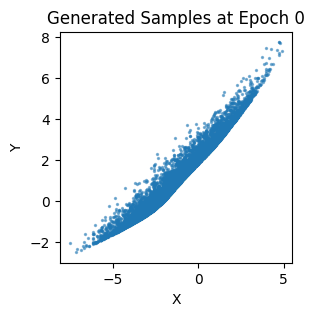

Epoch 50: D Loss = 1.4011, G Loss = 0.6917
Sample LDR values:
  Class 0: 0.0019
  Class 1: 0.0261


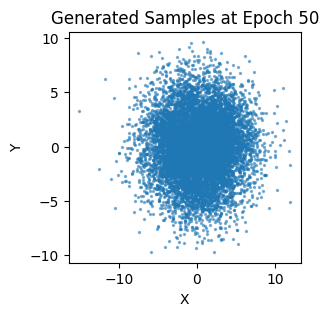

Epoch 100: D Loss = 1.3936, G Loss = 0.6928
Sample LDR values:
  Class 0: -0.0067
  Class 1: -0.0448


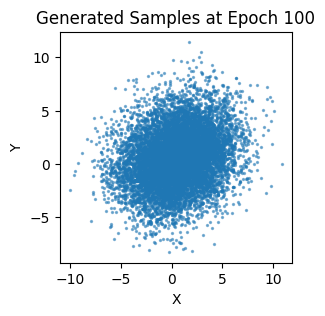

Epoch 150: D Loss = 1.3860, G Loss = 0.6885
Sample LDR values:
  Class 0: 0.0086
  Class 1: 0.0207


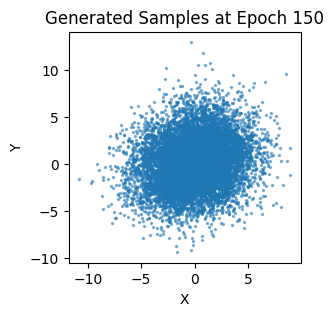

Table 1: Averaged LDRV of major/minor groups on Gaussian dataset
| Group | Gaussian (σ=1.0) |
|-------|------------------|
| Major | 0.019           |
| Minor | 0.185           |


In [27]:
generator = Generator(2)
discriminator = Discriminator()
data, labels = generate_gaussian_dataset()
ldrm_values, d_losses, g_losses, ldr_history = train_BasicGAN(generator, discriminator, data, labels, latent_dim=2, n_epochs=200)
major_ldrv, minor_ldrv = compute_LDRV_table(ldr_history, labels)
